# Preparing text data as input for pretrained DistilBERT model

## Importing pandas dataframes

Get all pkl files from directory of cleaned datasets

In [1]:
import os
import pandas as pd

In [2]:
PATH = "../data/cleaned/"
list_files = [f for f in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, f))) and (f[-3:] == "pkl")]

dict_dfs = {}
for file_name in list_files:
    file_path = os.path.join(PATH, file_name)
    df = pd.read_pickle(file_path)
    df = df[["id", "created_at", "content_only_alphanum", "content_length_alphanum", "trend"]]
    dict_dfs[file_name] = df

## EDA

### Prepare datasets for EDA

One single dataset

In [3]:
col_names = dict_dfs[list(dict_dfs.keys())[0]].columns
df_all = pd.DataFrame(columns = col_names)
for df_name in dict_dfs:
    dict_dfs[df_name]["orig_df"] = df_name
    df_all = pd.concat([df_all, dict_dfs[df_name]])
df_all = df_all.reset_index(drop = True)

/tmp/ipykernel_12342/3168140750.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, dict_dfs[df_name]])


Get a new column for 'trending or not' and remove cases with too short content.

In [4]:
df_all["trending"] = df_all["trend"].map(lambda x: 1 if x == "trending" else 0)
df_all["content_length_alphanum"] = df_all["content_length_alphanum"].astype("int64")
df_all = df_all[df_all["content_length_alphanum"] > 2]

One dataset for 'any adjacent', and one for 'account focused adjacent':

In [5]:
df_trd = df_all[df_all["trend"] == "trending"].drop_duplicates(subset = "id", keep = "first")
df_adj_any = df_all[df_all["trend"].isin(["adjacent_1", "adjacent_3"])].drop_duplicates(subset = "id", keep = "first")
df_adj_acc = df_all[df_all["trend"].isin(["adjacent_2", "adjacent_4"])].drop_duplicates(subset = "id", keep = "first")
df_any = pd.concat([df_trd, df_adj_any]).drop_duplicates(subset = "id", keep = "first").reset_index(drop = True)
df_acc = pd.concat([df_trd, df_adj_acc]).drop_duplicates(subset = "id", keep = "first").reset_index(drop = True)

### Inspect content lenght

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='content_length_alphanum', ylabel='Count'>

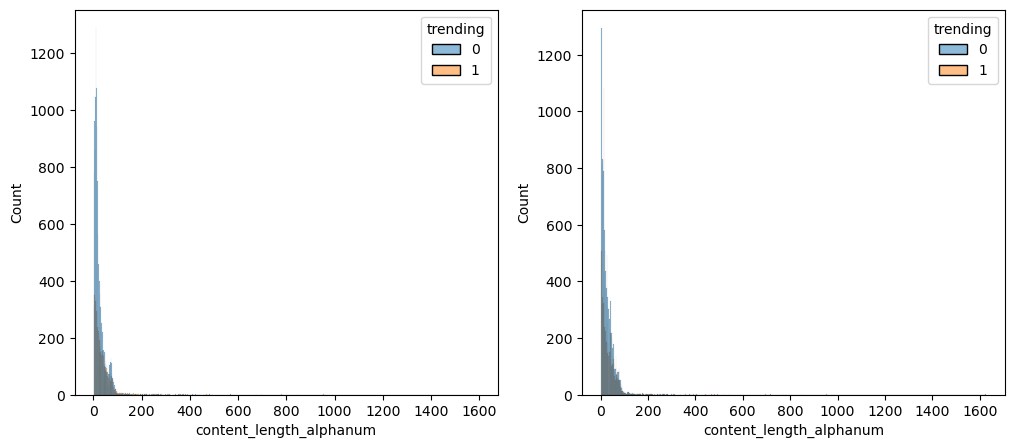

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
sns.histplot(data = df_any, ax = ax1, x = "content_length_alphanum", hue = "trending")
sns.histplot(data = df_acc, ax = ax2, x = "content_length_alphanum", hue = "trending")

In [8]:
print(df_any["content_length_alphanum"].describe())
print(df_any.groupby("trending")["content_length_alphanum"].quantile(0.95)) 
print(df_any.groupby("trending")["content_length_alphanum"].quantile(0.99)) 
print(df_acc["content_length_alphanum"].describe())
print(df_acc.groupby("trending")["content_length_alphanum"].quantile(0.95))
print(df_acc.groupby("trending")["content_length_alphanum"].quantile(0.99))

count    20186.000000
mean        28.406420
std         34.636369
min          3.000000
25%         11.000000
50%         18.000000
75%         37.000000
max       1596.000000
Name: content_length_alphanum, dtype: float64
trending
0    74.0
1    82.0
Name: content_length_alphanum, dtype: float64
trending
0     99.00
1    164.82
Name: content_length_alphanum, dtype: float64
count    19000.000000
mean        29.623474
std         34.974979
min          3.000000
25%         11.000000
50%         21.000000
75%         40.000000
max       1624.000000
Name: content_length_alphanum, dtype: float64
trending
0    73.0
1    82.0
Name: content_length_alphanum, dtype: float64
trending
0    113.00
1    164.82
Name: content_length_alphanum, dtype: float64


## Prepare text data

Let's focus on 'account-focused' control cases, and split this dataframe for training-validation-testing, unsing original datasets as reference (5 for training, 2 for validation, 2 for testing).

In [26]:
dict_dfs_text = {}
dict_dfs_text["train"] = df_acc[df_acc["orig_df"].isin(list_files[:5])]
dict_dfs_text["valid"] = df_acc[df_acc["orig_df"].isin(list_files[5:7])]
dict_dfs_text["test"] = df_acc[df_acc["orig_df"].isin(list_files[7:])]

Keep only text and label, and rename.

In [27]:
map_col_names = {"content_only_alphanum": "text", "trending" : "label"}
for df_name in dict_dfs_text:
    dict_dfs_text[df_name] = dict_dfs_text[df_name][map_col_names.keys()].rename(columns = map_col_names)

Save

In [31]:
import os
if not os.path.exists("../data/text"):
    os.mkdir("../data/text")

for split in dict_dfs_text:
    dict_dfs_text[split].to_csv(f"../data/text/acc_{split}.csv", index = False)